In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.models import Sequential
from keras.layers import *
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
remote = callbacks.RemoteMonitor(root='http://localhost:9000')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras.utils.visualize_util import plot
from keras.optimizers import *
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import csv
from sklearn.metrics import log_loss
from PIL import Image
import os
import random
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import model_from_json
from keras.applications.resnet50 import preprocess_input, decode_predictions
from convnetskeras.customlayers import Softmax4D
import gc
from convnetskeras.convnets import preprocess_image_batch, convnet
from convnetskeras.imagenet_tool import synset_to_dfs_ids
import PIL
from PIL import Image,ImageFilter, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from matplotlib.patches import Ellipse
from numpy.linalg import eig, inv
import scipy
from scipy import ndimage
from skimage import data, io, filters
from skimage import data, img_as_float
from skimage import exposure
import math
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
import skimage
import collections
import json
import pickle

Using Theano backend.
Using gpu device 0: GeForce GTX 960M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)


In [2]:
import numpy as np
from keras.layers.core import  Lambda, Merge
from keras.layers.convolutional import Convolution2D
from keras import backend as K
from keras.engine import Layer
from os import listdir
from os.path import isfile, join, dirname
from scipy.io import loadmat
import gc
from keras.utils.layer_utils import layer_from_config
from keras.models import Model
from keras.layers import *

# Credits to heuritech for their great code which was a great inspiration.
# Some of the code comes directly from their repository.
# You can look it up: https://github.com/heuritech/convnets-keras


def depthfirstsearch(id_, out=None):
    if out is None:
        out = []
    if isinstance(id_, int):
        pass
    else:
        id_ = next(int(s[0]) for s in synsets if s[1][0] == id_)
        
    out.append(id_)
    children = synsets[id_-1][5][0]
    for c in children:
        depthfirstsearch(int(c), out)
    return out
	
# This is to find all the outputs that correspond to the class we want.
def synset_to_dfs_ids(synset):
    ids = [x for x in depthfirstsearch(synset) if x <= 1000]
    ids = [corr[x] for x in ids]
    return ids
	
# Keras doesn't have a 4D softmax. So we need this.
class Softmax4D(Layer):
    def __init__(self, axis=-1,**kwargs):
        self.axis=axis
        super(Softmax4D, self).__init__(**kwargs)

    def build(self,input_shape):
        pass

    def call(self, x,mask=None):
        e = K.exp(x - K.max(x, axis=self.axis, keepdims=True))
        s = K.sum(e, axis=self.axis, keepdims=True)
        return e / s

    def get_output_shape_for(self, input_shape):
        return input_shape
		

def get_dim(model, layer_index, input_shape=None):
    
    # Input shape is the shape of images used during training.
    if input_shape is not None:
        dummy_vector = np.zeros((1,) + input_shape)
    else:
        if model.layers[0].input_shape[2] is None:
            raise ValueError('You must provide \"input_shape = (3,256,256)\" for example when calling the function.')
        dummy_vector = np.zeros((1,) + model.layers[0].input_shape[1:])
    
    intermediate_layer_model = Model(input=model.input,
                                 output=model.layers[layer_index].output)
    
    out = intermediate_layer_model.predict(dummy_vector)
    
    return out.shape[1:]
	

def from_config(layer, config_dic):
    config_correct = {}
    config_correct['class_name'] = type(layer)
    config_correct['config'] = config_dic
    return layer_from_config(config_correct)
	

def add_to_model(x, layer):
    new_layer = from_config(layer, layer.get_config())
    x = new_layer(x)
    if layer.get_weights() is not None:
        new_layer.set_weights(layer.get_weights())
    return x
	

def layer_type(layer):
    return str(layer)[10:].split(" ")[0].split(".")[-1]
	

def detect_configuration(model):
    # must return the configuration and the number of the first pooling layer
    
    # Names (types) of layers from end to beggining
    inverted_list_layers = [layer_type(layer) for layer in model.layers[::-1]]
    
    layer1 = None
    layer2 = None 
    
    i = len(model.layers)
    
    for layer in inverted_list_layers:
        i -= 1
        if layer2 is None:
            if layer == "GlobalAveragePooling2D" or layer == "GlobalMaxPooling2D":
                layer2 = layer

            elif layer == "Flatten":
                return "local pooling - flatten", i-1
            
        else:
            layer1 = layer
            break
            
    if layer1 == "MaxPooling2D" and layer2 == "GlobalMaxPooling2D":
        return "local pooling - global pooling (same type)", i
    elif layer1 == "AveragePooling2D" and layer2 == "GlobalAveragePooling2D":
        return "local pooling - global pooling (same type)", i
    
    elif layer1 == "MaxPooling2D" and layer2 == "GlobalAveragePooling2D":
        return "local pooling - global pooling (different type)", i+1
    elif layer1 == "AveragePooling2D" and layer2 == "GlobalMaxPooling2D":
        return "local pooling - global pooling (different type)", i+1
    
    else:
        return "global pooling", i
		
    
def add_zeros(w, nb_zeros):
    
    n = w.shape[3]
    indexes = np.array(range(1, n))
    w1 = w
    for i in range(nb_zeros):
        w1 = np.insert(w1, indexes + i, 0, axis=2)
    for i in range(nb_zeros):
        w1 = np.insert(w1, indexes + i, 0, axis=3)
    return w1
	
    
def insert_weights(layer, new_layer):
    W,b = layer.get_weights()
    n_filter,previous_filter,ax1,ax2 = new_layer.get_weights()[0].shape
    ax1 = ax2 = int(np.sqrt(layer.get_weights()[0].shape[0]/new_layer.get_weights()[0].shape[1]))
    new_W = W.reshape((previous_filter,ax1,ax2,n_filter))
    new_W = new_W.transpose((3,0,1,2))
    new_W = new_W[:,:,::-1,::-1]
	
    
    if ax1!=1:
        insert_zeros = int((new_layer.get_weights()[0].shape[2] - ax1)/(ax1-1))
        print("insert_zeros=" + str(insert_zeros))
        new_W =  add_zeros(new_W, insert_zeros)
    
    new_layer.set_weights([new_W,b])
	
    
def copy_last_layers(model, begin,x):
    
    i=begin
    
    for layer in model.layers[begin:]:
        if layer_type(layer) == "Dense":
            
            if i == len(model.layers)-1:
                x = add_reshaped_layer(layer,x,1, no_activation=True)
            else:
                x = add_reshaped_layer(layer,x,1)
            
        elif layer_type(layer) == "Dropout":
            pass
                
        elif layer_type(layer) == "Activation" and i == len(model.layers)-1:
            break
               
        else:
            x = add_to_model(x, layer)
        i+=1
    
    x = Softmax4D(axis=1,name="softmax")(x)
    return x
    
                
def add_reshaped_layer(layer, x, size, no_activation=False, add_zeros = None):

    conf = layer.get_config()
    
    if no_activation:
        activation="linear"
    else:
        activation=conf["activation"]
        
    #size = int(np.sqrt(layer.get_weights()[0].shape[0]/conf["output_dim"]))
    
    new_layer = Convolution2D(conf["output_dim"],size,size, activation=activation, name=conf['name'])
         
        
    x= new_layer(x)
    # We transfer the weights:
    insert_weights(layer, new_layer)
    return x
    

def to_heatmap(model, input_shape = None, delete = False):
    
    # there are four configurations possible:
    # global pooling
    # local pooling - flatten
    # local pooling - global pooling (same type)
    # local pooling - global pooling (different type)
    
    model_type, index = detect_configuration(model)
    
    print("Model type detected: " + model_type)
    
    #new_layer.set_weights(model.layers[0].get_weights())
    img_input = Input(shape=(3,None,None))
   
    # Inchanged part:
    middle_model = Model(input=model.layers[1].input, output=model.layers[index-1].output)
    
    x = middle_model(img_input)
    
    print("Model cut at layer: " + str(index))
        
    if model_type == "global pooling":
        x = copy_last_layers(model, index+1,x)
              
    elif model_type == "local pooling - flatten":
        
        layer = model.layers[index]
        dic = layer.get_config()
        add_zeros = dic["strides"][0] - 1
        dic["strides"] = (1,1)
        new_pool = from_config(layer, dic)
        x = new_pool(x)
        
        size = get_dim(model, index, input_shape)[1]
        print("Pool size infered: " + str(size))
        
        conv_size = size + (size-1) * add_zeros
        
        print("New convolution size: " + str(conv_size))
        
        if index+2 != len(model.layers)-1:
            x = add_reshaped_layer(model.layers[index+2],x,conv_size, add_zeros=add_zeros)
        else:
            x = add_reshaped_layer(model.layers[index+2],x,conv_size, add_zeros=add_zeros,no_activation=True)
            
        x = copy_last_layers(model, index+3,x)
        
        
    elif model_type == "local pooling - global pooling (same type)":
        
        
        dim = get_dim(model, index, input_shape=input_shape)

        new_pool_size = model.layers[index].get_config()["pool_size"][0] * dim[1]
        
        print("Pool size infered: " + str(new_pool_size))
        
        x = AveragePooling2D(pool_size=(new_pool_size, new_pool_size), strides=(1,1)) (x)
        x = copy_last_layers(model, index+2,x)
        
        
    elif model_type == "local pooling - global pooling (different type)":
        x= copy_last_layers(model, index+1,x)
    else:
        raise IndexError("no type for model: " + str(model_type))
        
    
    
    if delete:
        del(model)
        gc.collect()
        print("Original model was deleted.")
    
    return Model(img_input, x)

In [4]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
res_model = ResNet50(weights='imagenet', include_top=True,input_shape = (3,224,224))
new_res_model = to_heatmap(res_model, input_shape = (3,224,224), delete=False)
new_res_model.compile(optimizer=sgd, loss='mse')

Model type detected: local pooling - flatten
Model cut at layer: 174
Pool size infered: 1
New convolution size: 1


In [3]:
jsons = [f for f in os.listdir('./') if '.json' in f and 'labels' in f]
print(jsons)
data_json = collections.defaultdict(int)
for fjson in jsons:
    with open(fjson,'r+') as f:
        name = fjson.split('_')[0].upper()
        data_json[name] = collections.defaultdict(list)
        labels = json.load(f)
        for label in labels:
            img_name = label['filename'].split('/')[-1]
            data_json[name][img_name] = label['annotations'] 
print(data_json.keys())

['alb_labels.json', 'bet_labels.json', 'dol_labels.json', 'lag_labels.json', 'other_labels.json', 'shark_labels.json', 'yft_labels.json']
dict_keys(['ALB', 'BET', 'YFT', 'OTHER', 'LAG', 'SHARK', 'DOL'])


In [4]:
root = './heatmaps/'
model = 'RESTNET50/'
train = 'train/'
test = 'test/'
obj = [direc for direc in os.listdir('./train/train/') if direc!='.DS_Store']
print(obj)
#create model dir
try:
    os.stat(root+model+train)
except:
    os.mkdir(root+model+train)
#create train and test
try:
    os.stat(root+model+train)
except:
    os.mkdir(root+model+train)
try:
    os.stat(root+model+test)
except:
    os.mkdir(root+model+test)
#create classes   
for direc in obj:
    try:
        os.stat(root+model+train+direc)
    except:
        os.mkdir(root+model+train+direc)
for direc in obj:
    try:
        os.stat(root+model+test+direc)
    except:
        os.mkdir(root+model+test+direc)
out_train = root+model+train
out_test = root+model+test
print(out_train)

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
./heatmaps/RESTNET50/train/


In [4]:
# Create and save heatmaps
root_path_train = "./train/train/"
imgs = [{'class':str(f)+'/','imgs_name':[os.listdir(root_path_train+f)]} for f in os.listdir(root_path_train) if f!='.DS_Store']
imgs_N = np.array([len(os.listdir(root_path_train+f)) for f in os.listdir(root_path_train) if f!='.DS_Store'])

In [5]:
L = imgs_N.sum()

In [10]:
from convnetskeras.imagenet_tool import synset_to_dfs_ids
from tqdm import tqdm_notebook as tq
s = "n02512053"
data = collections.defaultdict(list)
alpha = 0.7
ids = synset_to_dfs_ids(s)
c = tq(total=L)
for i,img_obj in enumerate(imgs):
    classe = img_obj['class']
    path_class = root_path_train+classe
    count = 0
    for img_name in img_obj['imgs_name'][0]:
        if int(len(img_obj['imgs_name'][0])*alpha) > count:
            img_path = path_class+img_name
            img_output = out_train+classe+img_name
            img = image.load_img(img_path)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            out = new_res_model.predict(x)       
            heatmap_out = out[0,ids].sum(axis=0)
            heatmap_out = scipy.misc.imresize(heatmap_out, (100,100), interp='bilinear', mode=None)
            data[img_output]=[heatmap_out,img.size]
            count+=1
            c.update()
        else:
            img_path = path_class+img_name
            img_output = out_test+classe+img_name
            img = image.load_img(img_path)
            img = image.load_img(img_path)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            out = new_res_model.predict(x)       
            heatmap_out = out[0,ids].sum(axis=0)
            heatmap_out = scipy.misc.imresize(heatmap_out, (100,100), interp='bilinear', mode=None)
            data[img_output]=[heatmap_out,img.size]
            count+=1
            c.update()
c.close()

In [11]:
print(data[[key for key in data.keys()][0]])

[array([[  4,   4,   3, ...,  10,   8,   8],
       [  4,   4,   3, ...,  10,   8,   8],
       [  4,   4,   3, ...,  10,   8,   8],
       ..., 
       [  2,   2,   2, ..., 153, 140, 140],
       [  2,   2,   2, ..., 153, 140, 140],
       [  2,   2,   2, ..., 153, 140, 140]], dtype=uint8), (1280, 720)]


In [12]:
with open('data_heatmaps.g','wb') as f:
    pickle.dump(data, f, -1)

In [6]:
with open('data_heatmaps.g','rb') as f:
    unpickler = pickle.Unpickler(f);
    data_load = unpickler.load();

In [7]:
#print(data_json[list(data_json.keys())[0]])

In [8]:
keys_data_train = [[key,key.split('/')[-2],key.split('/')[-1]] for key in data_load.keys() if key.split('/')[-3] == 'train']
keys_data_test = [[key,key.split('/')[-2],key.split('/')[-1]] for key in data_load.keys() if key.split('/')[-3] == 'test']
print(keys_data_test[0])

['./heatmaps/RESTNET50/test/YFT/img_07368.jpg', 'YFT', 'img_07368.jpg']


In [9]:
real_data_train = collections.defaultdict(list)
real_data_test = collections.defaultdict(list)
for key in keys_data_train:
    classe = key[0]
    img = data_load[key[0]]
    classe = key[1]
    img_name = key[2]
    if key[1] != 'NoF':
        keys = [key for key in data_json[key[1]].keys()]
        if key[2] in keys:
            key_class = data_json[key[1]][key[2]]
            size = data_load[key[0]][1]
            real_data_train[classe+'_'+img_name] = [data_load[key[0]][0],data_json[key[1]][key[2]],size]
for key in keys_data_test:
    classe = key[0]
    img = data_load[key[0]]
    classe = key[1]
    img_name = key[2]
    if key[1] != 'NoF':
        keys = [key for key in data_json[key[1]].keys()]
        if key[2] in keys:
            key_class = data_json[key[1]][key[2]]
            size = data_load[key[0]][1]
            real_data_test[classe+'_'+img_name] = [data_load[key[0]][0],data_json[key[1]][key[2]],size]

[array([[ 1,  1,  1, ..., 37, 45, 45],
       [ 1,  1,  1, ..., 37, 45, 45],
       [ 1,  1,  1, ..., 37, 45, 45],
       ..., 
       [ 2,  2,  2, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  1,  1,  1]], dtype=uint8), [{'height': 180.22051110823685, 'class': 'rect', 'y': 356.2302626111411, 'width': 131.3756996863782, 'x': 797.5178692500015}], (1280, 720)] ALB_img_04296.jpg


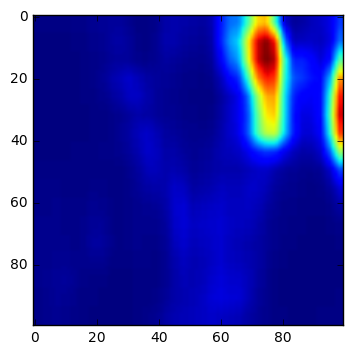

In [10]:
plt.imshow(real_data_train[[key for key in real_data_train.keys()][1]][0])
print(real_data_train[[key for key in real_data_train.keys()][1]],[key for key in real_data_train.keys()][1])

In [11]:
print(len(real_data_train.keys()),len(real_data_test.keys()))

2315 997


In [310]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    '''The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    '''
    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      border_mode='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = merge([x, input_tensor], mode='sum')
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    '''conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    '''
    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size, border_mode='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum')
    x = Activation('relu')(x)
    return x

In [311]:
# PREPARE DATA
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



In [312]:
def normalize_rect(obj):
    size = obj[2]
    rects = obj[1]
    mask = np.zeros((100,100))
    if len(rects) > 0 :
        x_r = size[0]
        y_r = size[1]
        for rect in rects:
            x = rect['x']*x_r
            y = rect['y']*y_r
            w = rect['width']*x_r
            h = rect['height']*y_r
            for n in range(size[0]-1):
                for k in range(size[1]-1):
                    if n > x and n < (x+w) and k > y and k < (y+h) and n < 100 and k < 100:
                            mask[k][n] = 1
       # img_array[idx]=mask[idx]
        return mask
    else:
        return mask

In [313]:
import operator
def min(a,b):
    if a > b:
        return b
    else:
        return a
def filter_rects(rects,th_x,th_y):
    rects_L = len(rects)
    area = []
    for i,rect in enumerate(rects) : 
        w = rect['width']
        h = rect['height']    
        area.append((i,h*w))
    tmp = sorted(area,key=operator.itemgetter(1),reverse=True)
    rects = [{'x': rects[tmp[i][0]]['x'], 'height': rects[tmp[i][0]]['height'], 'width': rects[tmp[i][0]]['width'], 'y': rects[tmp[i][0]]['y']} for i in range(min(BEST_RECTS,rects_L)) if rects[tmp[i][0]]['height']*rects[tmp[i][0]]['width'] > th_x*th_y]
    for i in range(MAX_FISH-len(rects)):
        rects.append({'x': 0, 'height': 0, 'width': 0, 'y': 0})
    return rects

In [325]:
def normalize_rect_list(obj):
    D = 15
    size = obj[2]
    th_x = size[0]/D
    th_y = size[1]/D
    rects = obj[1]
    output = []
    no_rect = 0
    L = len(rects)
    if len(rects) > 0 :
        x_r = 100/size[0]
        y_r = 100/size[1]
        rects = filter_rects(rects,th_x,th_y)
        if L < MAX_FISH:
            for i,rect in enumerate(rects):
                    x = rect['x']*x_r
                    y = rect['y']*y_r
                    w = rect['width']*x_r
                    h = rect['height']*y_r
                    output.append(x)
                    output.append(y)
                    output.append(w)
                    output.append(h)
            for i in range(MAX_FISH-len(output)):#MAX_FISH - len(output)
                for j in range(4):
                    output.append(no_rect)
            return output
        else:
            for i,rect in enumerate(rects):
                if i < MAX_FISH:
                    x = rect['x']*x_r
                    y = rect['y']*y_r
                    w = rect['width']*x_r
                    h = rect['height']*y_r
                    output.append(x)
                    output.append(y)
                    output.append(w)
                    output.append(h)
            return output
    else:
        return [no_rect for i in range(MAX_FISH*4)]

In [326]:
real_data_train_key = [key for key in real_data_train.keys()]
index = real_data_train_key[9]
print(index)
print(len(np.array(normalize_rect_list(real_data_train[index]))))
print(np.array(normalize_rect_list(real_data_train[index])))


BET_img_04568.jpg
24
[ 40.46875     26.28336756  22.421875    16.94045175   0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.        ]


In [327]:
#for i in range(100):
#    real_data_train_key = [key for key in real_data_train.keys()]
#    index = real_data_train_key[i]
#   print(i)
#    print(np.array(normalize_rect_list(real_data_train[index])))   
a = np.array(np.array(real_data_train[index][0])/255+np.random.normal(0, 0.05, (100,100)))
print(a.shape)
a = np.tile(a,(3,1,1))
print(a.shape)

(100, 100)
(3, 100, 100)


In [328]:
def expand_img(obj):
    return scipy.misc.imresize(np.tile(obj,(3,1,1)), (197,197), interp='bilinear', mode=None).transpose(2,0,1)

In [329]:
from tqdm import tqdm_notebook as tq
X = np.array([np.expand_dims(np.array(np.array(real_data_train[key][0])/255+np.random.normal(0, 0.1, (100,100))),axis=0) for key in tq(real_data_train.keys())])
#X = np.array([expand_img(np.array(real_data_train[key][0])/255+np.random.normal(0, 0.1, (100,100))) for key in tq(real_data_train.keys())])
Y = np.array([np.array(normalize_rect_list(real_data_train[key])) for key in tq(real_data_train.keys())])

In [330]:
x = np.array([np.expand_dims(np.array(np.array(real_data_test[key][0])/255),axis=0) for key in tq(real_data_test.keys())])
y = np.array([np.array(normalize_rect_list(real_data_test[key])) for key in tq(real_data_test.keys())])
print(X.shape)#
print(Y.shape)
print(Y[0].shape)
print(len(x))



(2315, 1, 100, 100)
(2315, 24)
(24,)
997


In [331]:
#with open('data_localizer.g','wb') as f:
#    pickle.dump([X,Y,x,y], f, -1)

In [332]:
#with open('data_localizer.g','rb') as f:
#    unpickler = pickle.Unpickler(f);
#    data_localizer = unpickler.load();
#    X = data_localizer[0]
#    Y = data_localizer[1]
#    x = data_localizer[2]
#    y = data_localizer[3]

In [333]:
#seed = 7
#numpy.random.seed(seed)
#estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=5, batch_size=5, verbose=0)
#kfold = KFold(n_splits=10, random_state=seed)
#results = cross_val_score(estimator, X, Y, cv=kfold)
#print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [334]:
# PREPARE MODEL
from keras.layers import merge, Input
from keras.regularizers import l2, activity_l2
MAX_FISH = 6
BEST_RECTS = 3
def baseline_model():
    # create model
    model = Sequential()
    model.add(Activation(activation="relu", input_shape=(1,100,100)))
    model.add(Dropout(0.1))

    model.add(Convolution2D(64, 3, 3,init='normal', border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3,init='normal', border_mode='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
 
    model.add(Convolution2D(128, 3, 3,init='normal', border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3,init='normal', border_mode='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512,init='normal'))
    
    model.add(Dense(128,init='normal'))
    model.add(Dropout(0.05))
    model.add(Dense(MAX_FISH*4,init='normal'))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0))
    return model
def return_resnet50(input_shape,input_tensor,include_top=False):
    if K.image_dim_ordering() == 'th':
        if include_top:
            input_shape = (3, 224, 224)
        else:
            input_shape = (3, None, None)
    else:
        if include_top:
            input_shape = (224, 224, 3)
        else:
            input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor)
        else:
            img_input = input_tensor
    # Block 1
    x = Convolution2D(32, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
    x = Convolution2D(32, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(64)(x)
    x = Dense(MAX_FISH*4)(x)
    model = Model(img_input, x)
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))
    return model

In [407]:
gc.collect()
#model = return_resnet50(input_shape=(3,197,197),input_tensor=None)
model = baseline_model()
model.fit(X, Y,
          batch_size=16, nb_epoch=100,callbacks=[remote],verbose=0,validation_data=(x, y), shuffle=True)
print(model.predict(x, batch_size=10))

KeyboardInterrupt: 

In [ ]:
import math
results = model.predict(x, batch_size=10)
scores = model.evaluate(x, y, verbose=0)
print(math.sqrt(scores))

In [ ]:
print(results[1])

In [ ]:
def plot_rect(img,rects,rights):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from PIL import Image
    import numpy as np
    fig,ax = plt.subplots(1)
    ax.imshow(img[0])
    dist0=math.fabs(np.subtract(rects,rights).sum())
    if len(rects) > 4 :
        rects = rects.reshape((MAX_FISH,4))
    else:
        rects = np.array([rects])
    if len(rights) > 4 :
        rights = rights.reshape((MAX_FISH,4))
    else:
        rights = np.array([rights])
    print(rects)
    for rect in rects:
        #rect*=100
        x = rect[0]
        y = rect[1]
        w = rect[2]
        h = rect[3]
        condition = w*h > 50 or (w>7 and h>5) or (w>5 and h>7)
        print(  condition)
        if condition:
            print(x,y,w,h)
            rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='red')
            ax.add_patch(rect)
        else:
            if w > 0 or h > 0:
                print(x,y,w,h)
            else:
                print("-1")
    for right in rights:
        #right*=100
        x = right[0]
        y = right[1]
        w = right[2]
        h = right[3]
        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='yellow')
        ax.add_patch(rect)
    dist = 0
    for rect in rects:
        for right in rights:
            dist+=math.fabs(np.subtract(rect,right).sum()/len(rect))
    print(dist0,math.sqrt(dist))
    plt.show()

In [ ]:
#dir(np)

[[  3.84756775e+01   4.29657249e+01   1.12969561e+01   2.01156559e+01]
 [  1.90780468e+01   3.48350596e+00   6.91882324e+00   2.57393241e+00]
 [  8.29838657e+00   2.25756931e+00   4.41363811e+00   3.35183668e+00]
 [  1.19456416e-02  -3.74459475e-02   1.95536185e-02   7.32836314e-03]
 [ -4.19753343e-02   6.47317059e-03  -2.71106735e-02  -2.19398048e-02]
 [  1.18779223e-02   1.51532190e-02  -2.06365101e-02   2.60269791e-02]]
True
38.4757 42.9657 11.297 20.1157
False
19.078 3.48351 6.91882 2.57393
False
8.29839 2.25757 4.41364 3.35184
False
0.0119456 -0.0374459 0.0195536 0.00732836
False
-1
False
0.0118779 0.0151532 -0.0206365 0.026027
45.86997636055752 18.42156148131579


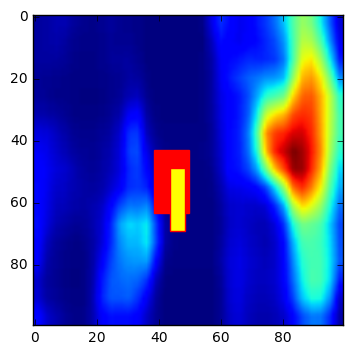

[[  3.97690697e+01   4.21909065e+01   1.71910248e+01   2.09864349e+01]
 [  2.23644428e+01   1.43362923e+01   9.04958439e+00   9.66292000e+00]
 [  9.02638340e+00   2.33109856e+00   3.10394883e+00   3.03936577e+00]
 [ -9.47103836e-03  -1.47599205e-02   2.14321334e-02  -4.25718874e-02]
 [ -1.86533872e-02   1.24545190e-02   4.28932272e-02  -1.87236685e-02]
 [  5.14588729e-02   1.70478895e-02  -4.34738062e-02   5.75410109e-03]]
True
39.7691 42.1909 17.191 20.9864
True
22.3644 14.3363 9.04958 9.66292
False
9.02638 2.3311 3.10395 3.03937
False
-0.00947104 -0.0147599 0.0214321 -0.0425719
False
-0.0186534 0.0124545 0.0428932 -0.0187237
False
0.0514589 0.0170479 -0.0434738 0.0057541
72.9940950946051 19.320915289165708


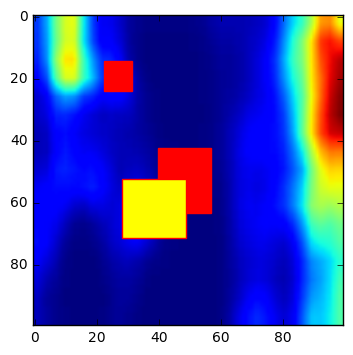

[[  3.54130440e+01   6.23298607e+01   2.06092968e+01   2.19170265e+01]
 [ -2.17706823e+00  -1.31642854e+00   3.63528895e+00   8.54194939e-01]
 [  1.34828138e+01   9.52412224e+00   5.08674717e+00   4.11218691e+00]
 [ -7.09982738e-02   2.68311314e-02  -7.81769902e-02  -5.14859781e-02]
 [  1.40037965e-02  -9.09264088e-02   8.17462429e-03   5.68620525e-02]
 [ -8.21885094e-02   1.03232995e-01  -6.63575754e-02  -2.80273147e-02]]
True
35.413 62.3299 20.6093 21.917
False
-2.17707 -1.31643 3.63529 0.854195
False
13.4828 9.52412 5.08675 4.11219
False
-1
False
0.0140038 -0.0909264 0.00817462 0.0568621
False
-1
51.73709694563564 19.117249168520637


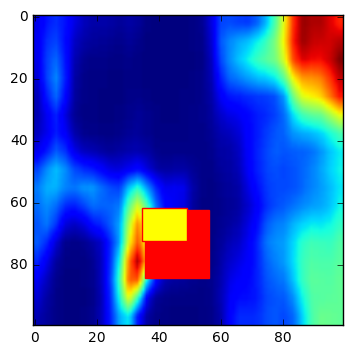

[[ 40.84721375  41.10650635  27.17293739  31.41666031]
 [  1.65414536   3.19738293   0.47913769   1.39645541]
 [  4.83108759   4.92210436   1.80522442   1.81534088]
 [ -0.1124635    0.07643266  -0.10050933  -0.11507894]
 [  0.05603398  -0.11908104   0.0755154    0.10535979]
 [ -0.07089553   0.1252643   -0.12067179  -0.07300169]]
True
40.8472 41.1065 27.1729 31.4167
False
1.65415 3.19738 0.479138 1.39646
False
4.83109 4.9221 1.80522 1.81534
False
-1
False
0.056034 -0.119081 0.0755154 0.10536
False
-1
8.287165292032256 19.735103583707208


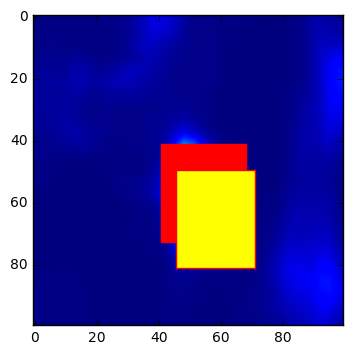

[[  3.68106651e+01   5.55738869e+01   1.87647305e+01   1.83506279e+01]
 [  1.37343426e+01   1.27750120e+01   3.90849209e+00   5.61511278e+00]
 [  5.47842646e+00  -3.77628350e+00   1.59078085e+00   1.16323030e+00]
 [ -9.87993851e-02   8.73901099e-02  -5.21332584e-02  -9.56629142e-02]
 [  7.65755996e-02  -7.87891597e-02   1.04442932e-01   8.73394310e-02]
 [ -7.89799765e-02   1.09425351e-01  -1.20088495e-01  -8.84914771e-02]]
True
36.8107 55.5739 18.7647 18.3506
False
13.7343 12.775 3.90849 5.61511
False
5.47843 -3.77628 1.59078 1.16323
False
-1
False
0.0765756 -0.0787892 0.104443 0.0873394
False
-1
59.094724903089855 18.60594221613767


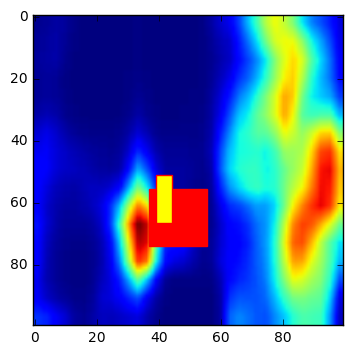

[[  4.43616905e+01   5.32707329e+01   1.90037251e+01   1.31303053e+01]
 [  1.15139353e+00  -4.42346764e+00   3.50426674e+00  -2.28309751e+00]
 [  1.13984108e+01   1.01644440e+01   3.12328792e+00   3.76354122e+00]
 [ -6.74905926e-02   1.48977861e-02  -7.37788305e-02  -4.79350165e-02]
 [  2.40624007e-02  -9.71603096e-02  -2.49754600e-02   4.57850508e-02]
 [ -7.27427825e-02   9.95784029e-02  -4.18985561e-02  -3.39882486e-02]]
True
44.3617 53.2707 19.0037 13.1303
False
1.15139 -4.42347 3.50427 -2.2831
False
11.3984 10.1644 3.12329 3.76354
False
-1
False
0.0240624 -0.0971603 -0.0249755 0.0457851
False
-1
50.62916995522818 18.216739766609898


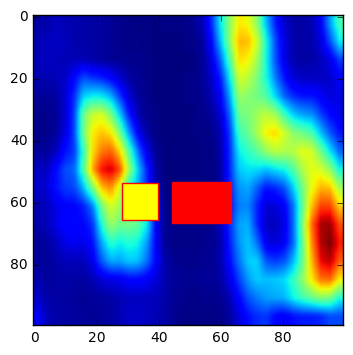

[[ 27.57887077  47.53564072  27.61315346  20.66178131]
 [  0.4293738   -7.33127642   0.55786979  -0.5416308 ]
 [ -4.12706423  -4.42866087  -1.00893879  -0.8288126 ]
 [ -0.15105511   0.11591879  -0.14978667  -0.09915159]
 [  0.08629818  -0.16599183   0.06836425   0.16217504]
 [ -0.15400121   0.15745978  -0.12877077  -0.10533038]]
True
27.5789 47.5356 27.6132 20.6618
False
0.429374 -7.33128 0.55787 -0.541631
False
-1
False
-1
False
0.0862982 -0.165992 0.0683642 0.162175
False
-1
8.835556606889078 18.069526617525494


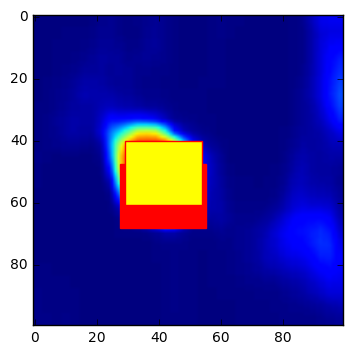

[[  6.05107613e+01   2.15777016e+01   3.30299797e+01   2.62490578e+01]
 [  2.02370434e+01   9.50685883e+00   1.00656853e+01   1.07810402e+01]
 [  6.63939381e+00   8.02585602e+00   4.04467201e+00   4.06557703e+00]
 [  1.61393303e-02  -7.96703547e-02   1.64328907e-02  -4.05514911e-02]
 [ -7.07748383e-02   1.10095236e-02   7.19079748e-03  -1.94572397e-02]
 [  6.95975050e-02   5.80432042e-02  -1.03924274e-02   4.02030274e-02]]
True
60.5108 21.5777 33.03 26.2491
True
20.237 9.50686 10.0657 10.781
False
6.63939 8.02586 4.04467 4.06558
False
0.0161393 -0.0796704 0.0164329 -0.0405515
False
-0.0707748 0.0110095 0.0071908 -0.0194572
False
0.0695975 0.0580432 -0.0103924 0.040203
97.77827177010425 20.069067625996915


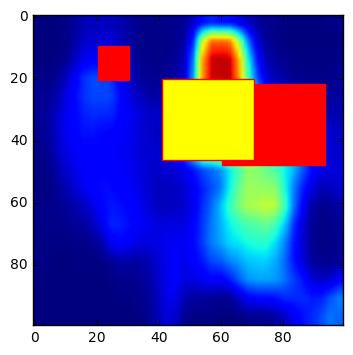

[[ 45.22797012  56.61839676  25.79613304  21.60602951]
 [ -6.6774106   -2.41393638  -0.42300674  -0.90963322]
 [  1.44317305  -1.72406709   0.09960502   0.30187574]
 [ -0.15852003   0.12657268  -0.15553567  -0.13709553]
 [  0.11239837  -0.19574375   0.06941219   0.17820781]
 [ -0.17124559   0.17800556  -0.13964796  -0.13264391]]
True
45.228 56.6184 25.7961 21.606
False
-1
False
1.44317 -1.72407 0.099605 0.301876
False
-1
False
0.112398 -0.195744 0.0694122 0.178208
False
-1
4.0092622186028635 19.36979175773384


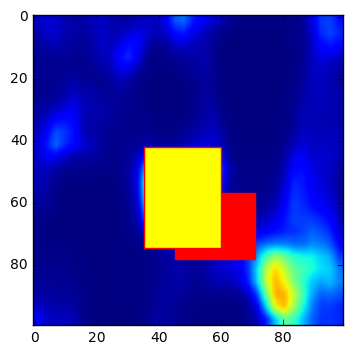

[[  4.55381737e+01   1.99012625e+00   3.30239944e+01   2.51191921e+01]
 [  2.43802299e+01   9.06748390e+00   1.73288536e+01   1.82935963e+01]
 [  3.62654269e-01  -3.22661424e+00  -8.24271142e-01  -1.39435306e-02]
 [  4.49410006e-02  -1.22627400e-01   4.66665626e-02   1.28496401e-02]
 [ -1.08813837e-01   5.64600825e-02  -1.28347762e-02  -5.27532026e-02]
 [  1.47617251e-01  -2.30801180e-02   1.16079003e-02   8.45315605e-02]]
True
45.5382 1.99013 33.024 25.1192
True
24.3802 9.06748 17.3289 18.2936
False
-1
False
0.044941 -0.122627 0.0466666 0.0128496
False
-1
False
0.147617 -0.0230801 0.0116079 0.0845316
38.155473642879066 20.265975258559443


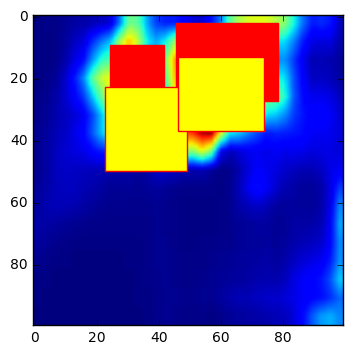

In [408]:
for p in range(10):
    plot_rect(x[p]*255,results[p],y[p])

In [ ]:
for p in range(10):
    plot_rect(X[p]*255,results[p],Y[p])